In [15]:
% load_ext autoreload
% autoreload 2
from matplotlib.colors import LogNorm, Normalize
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from helpers import set_size
from tqdm import tqdm
import seaborn as sns
import numpy as np
import pickle
import cfrs


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
with open("mat2.pkl", "rb") as f:
    vals = pickle.load(f)

In [17]:
from collections import Counter
import pandas as pd
import scipy.stats as stats


def map_index_to_topic(val,
                       list_size=[20, 50, 70, 50, 20],
                       list_names=["L", "CL", "C", "CR", "R"]):
    cumsum = np.array(list_size).cumsum()
    return list_names[(val < cumsum).argmax()]


def measure_1_round(M, S, to_add, list_sizes, z=20, user_index=50, selection_mode='random'):
    rv = stats.poisson(z)
    tosses = z  # rv.rvs()
    tmp = np.copy(S.X[user_index, :])
    S.X[user_index, :] = np.random.random(S.X.shape[1]) / 10 ** 10
    for ta in to_add:
        S.X[user_index, ta] = 1
    dict_vals = []

    for i in range(tosses):

        scores, recommendations, choice = M.interact(user_index, S, selection_mode=selection_mode)

        tmpd = pd.DataFrame({
            "T": [map_index_to_topic(rec, list_sizes) for rec in recommendations],
            "S": scores
        })

        for label in [map_index_to_topic(rec, list_sizes) for rec in recommendations]:
            dict_vals.append({
                "idx": i,
                "user_index": user_index,
                "label": label,
                "kind": "recommendation"
            })
        dict_vals.append({
            "idx": i,
            "user_index": user_index,
            "label": map_index_to_topic(choice, list_sizes),
            "kind": "choice"
        })

    S.X[user_index, :] = tmp

    return pd.DataFrame(dict_vals).fillna(0)

## Experiment 1

In [18]:
recompute = True

if recompute:
    dfs = []
    for sim in tqdm(range(vals["num_matrices"])):
        tmp = vals["matrices"][sim]
        M, S = tmp["M"], tmp["S"]
        tmp_list_sizes = [0] + list(vals["parameters"]["list_sizes"].cumsum())
        for lower, upper in zip(tmp_list_sizes[:-1], tmp_list_sizes[1:]):
            for i in range(300):
                to_add = [np.random.randint(lower, upper)]
                topic_start = map_index_to_topic(to_add[0], vals["parameters"]["list_sizes"])

                df = measure_1_round(M, S, to_add, vals["parameters"]["list_sizes"],
                                     z=20, user_index=np.random.randint(0, 600),
                                     selection_mode="random")
                df["idy"] = i
                df["sim"] = sim
                df["topic_start"] = topic_start
                dfs.append(df)
    dfs1 = pd.concat(dfs)
    dfs1.to_csv("df_exp1.csv.gz", index=False)
else:
    dfs1 = pd.read_csv("df_exp1.csv.gz")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:29:05<00:00, 53.45s/it]


## Experiment 2

In [49]:
recompute = True

tmp_list_sizes = [0] + list(vals["parameters"]["list_sizes"].cumsum())

if recompute:
    dfs = []
    for sim in tqdm(range(vals["num_matrices"])):
        tmp = vals["matrices"][sim]
        M, S = tmp["M"], tmp["S"]
        for i in range(300 * 6):
            user_index = np.random.randint(0, 600)
            tmp_list_sizes = np.array([0] + list(vals["parameters"]["list_sizes"].cumsum()))
            maxval = M.X[user_index, :].argmax()
            argmaxval = (tmp_list_sizes <= maxval).argmin()
            lower, upper = tmp_list_sizes[argmaxval - 1], tmp_list_sizes[argmaxval]
            to_add = [np.random.randint(lower, upper)]
            topic_start = map_index_to_topic(to_add[0], vals["parameters"]["list_sizes"])
            df = measure_1_round(
                M=M,
                S=S,
                to_add=to_add,
                list_sizes=vals["parameters"]["list_sizes"],
                z=20,
                user_index=user_index,
                selection_mode="utility"
            )
            df["idy"] = i
            df["sim"] = sim
            df["topic_start"] = topic_start
            dfs.append(df)
    dfs3 = pd.concat(dfs)
    dfs3.to_csv("df_exp2.csv.gz", index=False)
else:
    dfs3 = pd.read_csv("df_exp2.csv.gz")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:57:51<00:00, 70.72s/it]


# Plot

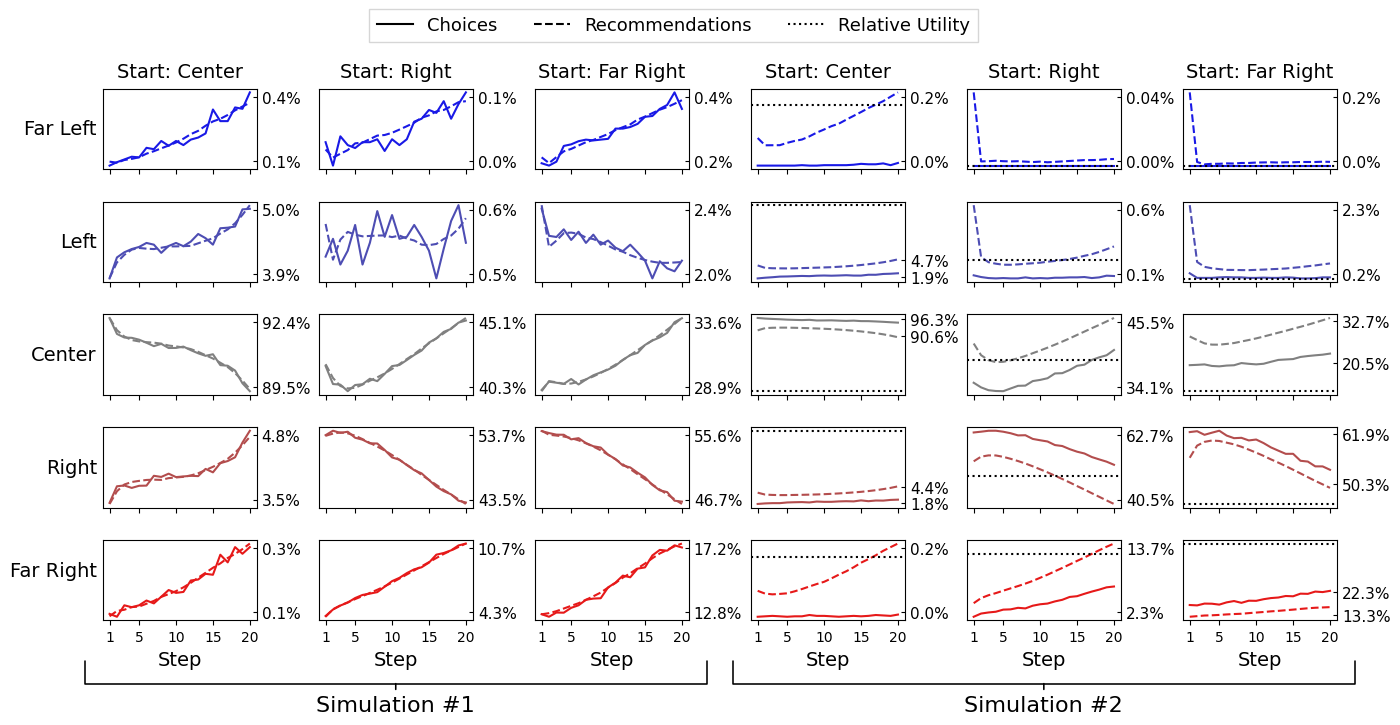

In [50]:

orie_to_low_hi = {'L': (0, 75),
                  'CL': (75, 200),
                  'C': (200, 400),
                  'CR': (400, 525),
                  'R': (525, 600)}

fig, axs_ = plt.subplots(5, 6, figsize=(14, 7.252),
                         gridspec_kw={"hspace": 0.4, "wspace": 0.4},
                         sharex=True)

from matplotlib.lines import Line2D

custom_lines = [Line2D([0], [0], color="#000", lw=1.5),
                Line2D([0], [0], color="#000", lw=1.5, ls="--"),
                Line2D([0], [0], color="#000", lw=1.5, ls=":")]

axs_[0, 3].legend(custom_lines, ['Choices', 'Recommendations', 'Relative Utility'], ncol=3, fontsize=13,
                  loc='upper center', bbox_to_anchor=(-0.5, 2.1), fancybox=False, shadow=False)

vals_names = np.array(
    [['Start:C/Measure:L', 'Start:CR/Measure:L', 'Start:R/Measure:L',
      'User:C/Measure:L', 'User:CR/Measure:L', 'User:R/Measure:L'],
     ['Start:C/Measure:CL', 'Start:CR/Measure:CL', 'Start:R/Measure:CL',
      'User:C/Measure:CL', 'User:CR/Measure:CL', 'User:R/Measure:CL'],
     ['Start:C/Measure:C', 'Start:CR/Measure:C', 'Start:R/Measure:C',
      'User:C/Measure:C', 'User:CR/Measure:C', 'User:R/Measure:C'],
     ['Start:C/Measure:CR', 'Start:CR/Measure:CR', 'Start:R/Measure:CR',
      'User:C/Measure:CR', 'User:CR/Measure:CR', 'User:R/Measure:CR'],
     ['Start:C/Measure:R', 'Start:CR/Measure:R', 'Start:R/Measure:R',
      'User:C/Measure:R', 'User:CR/Measure:R', 'User:R/Measure:R']]
)

plt.annotate('Simulation #1', xy=(0.5, -0.75), xytext=(0.5, -1.05), xycoords=axs_[4, 1].transAxes,
             fontsize=16, ha='center', va='center',
             arrowprops=dict(arrowstyle='-[, widthB=14.0, lengthB=1', lw=1.15))

plt.annotate('Simulation #2', xy=(0.5, -0.75), xytext=(0.5, -1.05), xycoords=axs_[4, 4].transAxes,
             fontsize=16, ha='center', va='center',
             arrowprops=dict(arrowstyle='-[, widthB=14.0, lengthB=1', lw=1.15))

axs = {}

for i, j in zip(vals_names.flatten(), axs_.flatten()):
    axs[i] = j

color_map = {
    "C": "#808080",
    "CL": "#4d4db3",
    "L": "#1919e6",
    "CR": "#b34d4d",
    "R": "#e61919"
}

ls_map = {
    "recommendation": "--", "choice": "-",
}

for dfs, strv_t in zip([dfs3, dfs1], ["User:{}/Measure:{}", "Start:{}/Measure:{}"]):
    for start in ["C", "CR", "R"]:
        tmp_ = dfs[dfs.topic_start == start]
        #         tmp_ = dfs
        for kind in ["recommendation", "choice"]:
            x = tmp_[tmp_.kind == kind].groupby(["idx", "label"]).count().idy.reset_index()
            x_norm = tmp_[tmp_.kind == kind].groupby(["idx"]).count().idy.reset_index()
            for measure in ["L", "CL", "C", "CR", "R"]:
                srtv = strv_t.format(start, measure)
                y = (x[x.label == measure].set_index("idx") / x_norm.set_index("idx")).fillna(0).idy

                axs[srtv].plot(y, color=color_map[measure], ls=ls_map[kind])
                lo, hi = axs[srtv].get_ylim()
                diff = (hi - lo) / 10
                axs[srtv].set_yticks([lo + diff, hi - diff])
                if (hi + diff) < 0.001:
                    axs[srtv].set_yticklabels([
                        "{:.2%}".format(lo + diff),
                        "{:.2%}".format(hi - diff)
                    ])
                else:
                    axs[srtv].set_yticklabels([
                        "{:.1%}".format(lo + diff),
                        "{:.1%}".format(hi - diff)
                    ])
                if kind == "choice" and "Start" not in strv_t:
                    lower, upper = orie_to_low_hi[measure]
                    prop = 0
                    sumprop = 0

                    tmp__ = tmp_[(tmp_.kind == "choice") & (tmp_.idx == 0)]

                    for useridx, idj in zip(tmp__.user_index, tmp__.sim):
                        prop += vals["matrices"][idj]["M"].X[useridx, lower:upper].sum()
                        sumprop += vals["matrices"][idj]["M"].X[useridx, :].sum()
                    hm = prop / sumprop
                    axs[srtv].axhline(hm, lw=1.5, ls=":", color="black")

axs_[0, 0].set_ylabel("Far Left", rotation=0, ha="right", size=14, va="center")
axs_[1, 0].set_ylabel("Left", rotation=0, ha="right", size=14, va="center")
axs_[2, 0].set_ylabel("Center", rotation=0, ha="right", size=14, va="center")
axs_[3, 0].set_ylabel("Right", rotation=0, ha="right", size=14, va="center")
axs_[4, 0].set_ylabel("Far Right", rotation=0, ha="right", size=14)
axs_[0, 0].set_title("Start: Center", rotation=0, ha="center", size=14, pad=8)
axs_[0, 1].set_title("Start: Right", rotation=0, ha="center", size=14, pad=8)
axs_[0, 2].set_title("Start: Far Right", rotation=0, ha="center", size=14, pad=8)
axs_[0, 3].set_title("Start: Center", rotation=0, ha="center", size=14, pad=8)
axs_[0, 4].set_title("Start: Right", rotation=0, ha="center", size=14, pad=8)
axs_[0, 5].set_title("Start: Far Right", rotation=0, ha="center", size=14, pad=8)
axs_[4, 0].set_xlabel("Step", size=14)
axs_[4, 1].set_xlabel("Step", size=14)
axs_[4, 2].set_xlabel("Step", size=14)
axs_[4, 3].set_xlabel("Step", size=14)
axs_[4, 4].set_xlabel("Step", size=14)
axs_[4, 5].set_xlabel("Step", size=14)

for axx in axs_.flatten():
    axx.set_xticks([0, 4, 9, 14, 19])
    axx.set_xticklabels(["1", "5", "10", "15", "20"])
    axx.yaxis.tick_right()
    axx.tick_params(axis="y", direction='in', size=3, labelsize=11)

set_size(fig, (14, 7.252))
fig.savefig("img/experiment.pdf", bbox_inches="tight")